# Model Evaluation Protocol
The Evaluation Protocol Will Evaluate the best hyperparameter configuration for each Learning Algorithm used in the model Selection.

Therefore, following Steps will be performed:
1. Train a model for each learning algorithm using the optimal hyperparameter configuration
-- Train the model on the whole cross validation dataset
2. Test each models performance using F1-Micro Score
-- The test will be performed using the test dataset
3. Analyze the Precision Recall Curve as well as the OvR ROC Curves for each model to determine whether one model is clearly better than the others
4. Determine the best performing model(s)/algorithm(s)


The Micro F1 Score is computed as follows:
we have 3 classes A, B, C

for class A we have:
TP: 1, FP: 1

for class B we have:
TP: 10, FP, 90

for class C we have:
TP: 1, FP, 1

it becomes visible, that there is an imbalance in the different classes and the amount of True Positives and False Positives

While Macro Average just computes the mean of the individual scores, Micro Average will compute it with respect to the actual weights of the classes
Micro precision for example will look as follows:
$Pr-micro = (1 + 10 + 1)/(2 + 90 + 2) = 0.127$ which means that the large amount of false positives from class B impacts the final Precision much more.

Macro Precision would look as follows:
$Pr-macro = (0.5 + 0.1 + 0.5)/3 = 0.66$

The fact that micro precision takes into account imbalances makes it suitable for this multiclass classification where the classes are indeed imbalanced.
However,this can also lead to the case that the model performs really well on the majority class and not so good on the other two but since the majority class dominates the numerical values,
the over all score is still good.
Therefore, the also macro average will be taken into account in later parts when the final models are selected.

In [2]:
import pandas as pd
from pandas import DataFrame


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, PrecisionRecallDisplay, RocCurveDisplay

# Load Data

In [3]:
path_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\cross_validation_data.csv"
path_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\test_data.csv"

cross_validation_data: DataFrame = pd.read_csv(path_cross_val_data, index_col="index")
x_cross_val: DataFrame = cross_validation_data.drop("target", axis=1)
y_cross_val: DataFrame = cross_validation_data.target

test_data: DataFrame = pd.read_csv(path_test_data, index_col="index")
x_test: DataFrame = test_data.drop("target", axis=1)
y_test: DataFrame = test_data.target

# also for scaled
path_scaled_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\scaled_cross_validation_data.csv"
path_scaled_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\scaled_test_data.csv"

scaled_cross_validation_data: DataFrame = pd.read_csv(path_scaled_cross_val_data, index_col="index")
x_cross_val_scaled: DataFrame = scaled_cross_validation_data.drop("target", axis=1)
y_cross_val_scaled: DataFrame = scaled_cross_validation_data.target

scaled_test_data: DataFrame = pd.read_csv(path_scaled_test_data, index_col="index")
x_test_scaled: DataFrame = scaled_test_data.drop("target", axis=1)
y_test_scaled: DataFrame = scaled_test_data.target

# Final Hyperparameter Combination for each of the trained Models

| Model Name | Class Weight |     Loss      | Max_Iter | Regularizer | Regularization Weight | F1 Score (Micro AVG) |
|------------|:------------:|:-------------:|:--------:|:-----------:|:---------------------:|:--------------------:|
| SVM        |   balanced   | squared_hinge |   1000   |     l2      |          1.0          |        0.9043        |

<br>
<br>

| Model Name    | Class Weight | Criterion | Max Depth | Min Sample Leaf | Number of Estimators | F1 Score (Micro AVG) |
|---------------|:------------:|:---------:|:---------:|:---------------:|:--------------------:|:--------------------:|
| Random Forest |   balanced   |  Entropy  |    200    |        2        |         200          |        0.9788        |

<br>
<br>

| Model Name    | Class Weight | Max Depth  | Min Sample Leaf | Criterion | F1 Score (Micro AVG) |
|---------------|:------------:|:----------:|:---------------:|:---------:|:--------------------:|
| Decision Tree |   balanced   |     10     |        2        |   gini    |        0.9707        |

<br>
<br>

| Model Name          | Class Weight | Max_Iter | Regularizer | Regularization Weight | F1 Score (Micro AVG) |
|---------------------|:------------:|:--------:|:-----------:|:---------------------:|:--------------------:|
| Logistic Regression |   balanced   |   2000   |     l1      |          1.0          |        0.9316        |


# Train a model for each algorithm using best hyperparameter

In [4]:
model_configurations: dict = {
    "svm": {
        "model": LinearSVC,
        "model_label": "Support Vector Machine",
        "hyperparameter": {
            "max_iter": 1000,
            "class_weight": "balanced",
            "loss": "squared_hinge",
            "penalty": "l2",
            "C": 1.0,
            "multi_class": "ovr",
        },
        "train_data": (x_cross_val_scaled, y_cross_val_scaled),
        "test_data": (x_test_scaled, y_test_scaled)
    },
    "random_forest": {
        "model": RandomForestClassifier,
        "model_label": "Random Forrest Classifier",
        "hyperparameter": {
            "n_estimators": 200,
            "min_samples_leaf": 2,
            "max_depth": 200,
            "class_weight": "balanced",
            "criterion": "entropy",

        },
        "train_data": (x_cross_val, y_cross_val),
        "test_data": (x_test, y_test)
    },
    "decision_tree": {
        "model": DecisionTreeClassifier,
        "model_label": "Decision Tree Classifier",
        "hyperparameter": {
            "max_depth": 10,
            "min_samples_leaf": 2,
            "criterion": "gini",
            "class_weight": "balanced"
        },
        "train_data": (x_cross_val, y_cross_val),
        "test_data": (x_test, y_test)
    },
    "log_reg": {
        "model": LogisticRegression,
        "model_label": "Logistic Regression Classifier",
        "hyperparameter": {
            "max_iter": 2000,
            "penalty": "l1",
            "C": 1.0,
            "class_weight": "balanced",
            "solver": "saga", # set the solver to saga. According to doc it is faster for large data and enables elastic net and l1 reg
            "multi_class": "ovr" # set the multiclass mode to ovr
        },
        "train_data": (x_cross_val_scaled, y_cross_val_scaled),
        "test_data": (x_test_scaled, y_test_scaled)
    },
}

# for roc auc ovr we need one hot encoded targets
label_binarizer = LabelBinarizer().fit(y_cross_val)
y_onehot_test = label_binarizer.transform(y_test)

for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]

    # data
    _x_train,  _y_train = model_config["train_data"]
    _x_test, _ = model_config["test_data"]

    # initialize and fit estimator
    estimator = model_config["model"](**model_config["hyperparameter"])
    estimator.fit(_x_train, _y_train)
    model_config["estimator"] = estimator

    # save predictions on test data as one-hot encodings
    model_config["test_one_hot_predictions"] = label_binarizer.transform(estimator.predict(_x_test))

    # predict_proba returns the fraction of each class in the terminal node: [p(Galaxy), p(Quasar), p(Star)] is returned
    if model_name == "svm":
        # svm does not have a predict_proba function save it as one hot encoding
        model_config["test_predictions_probabilities"] = label_binarizer.transform(estimator.predict(_x_test))

    else:
        model_config["test_predictions_probabilities"] = estimator.predict_proba(_x_test)

# Compute Micro and Macro F1 Score for each model

In [5]:
for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]
    _x_test, _y_test = model_config["test_data"]
    model_config["f1_macro"] = f1_score(y_true=_y_test, y_pred=model_config["estimator"].predict(_x_test), average="macro")
    model_config["f1_mirco"] = f1_score(y_true=_y_test, y_pred=model_config["estimator"].predict(_x_test), average="micro")
    print(f"Micro F1 on test data {model_config['model_label']:<35}: {model_config['f1_mirco']: <10}; Macro F1: {model_config['f1_macro']}")

Micro F1 on test data Support Vector Machine             : 0.91064   ; Macro F1: 0.9031664996535899
Micro F1 on test data Random Forrest Classifier          : 0.97992   ; Macro F1: 0.9766649603938395
Micro F1 on test data Decision Tree Classifier           : 0.97148   ; Macro F1: 0.9673674083091269
Micro F1 on test data Logistic Regression Classifier     : 0.93372   ; Macro F1: 0.9274749658097873


We find that the macro F1 score tends to be a bit worse for all models compared to the micro f1.
This can be caused when the models perform very good on the majority class which has a higher impact on the mico f1 than macro f1.
But since the discrepancy seems to be similar among all models this is not a problem but an observation.

# Plot Precision Recall Curve

The Precision Recall curve provides an overview about all pairs of precision and recall among various different thresholds of the decision function.
Since in this project deals with multiclass classification, the Precision Recall curve cannot be computed w.r.t to all three classes the same time.

As mentioned before, the One versus Rest method considers one class as the positive class and all other classes together as the negative class. This reduces the multiclass classification into a binary classification situation.
However, instead of one Precision Recall curve, the One versus Rest method produces N Precision Recall curves, where N is the number of unique classes.
Every class will be treated once as the positive class and N-1 times as part of the aggregated negative class.

e.g. In this project there exist three distinct classes namely:
GALAXY, QSA, STAR.

The OvR method will produce the following ROC curves
<br>

| Positive Class | Negative Class |
|:--------------:|:--------------:|
|     GALAXY     |   QSA + STAR   |
|      QSA       | GALAXY + STAR  |
|      STAR      |  QSA + GALAXY  |

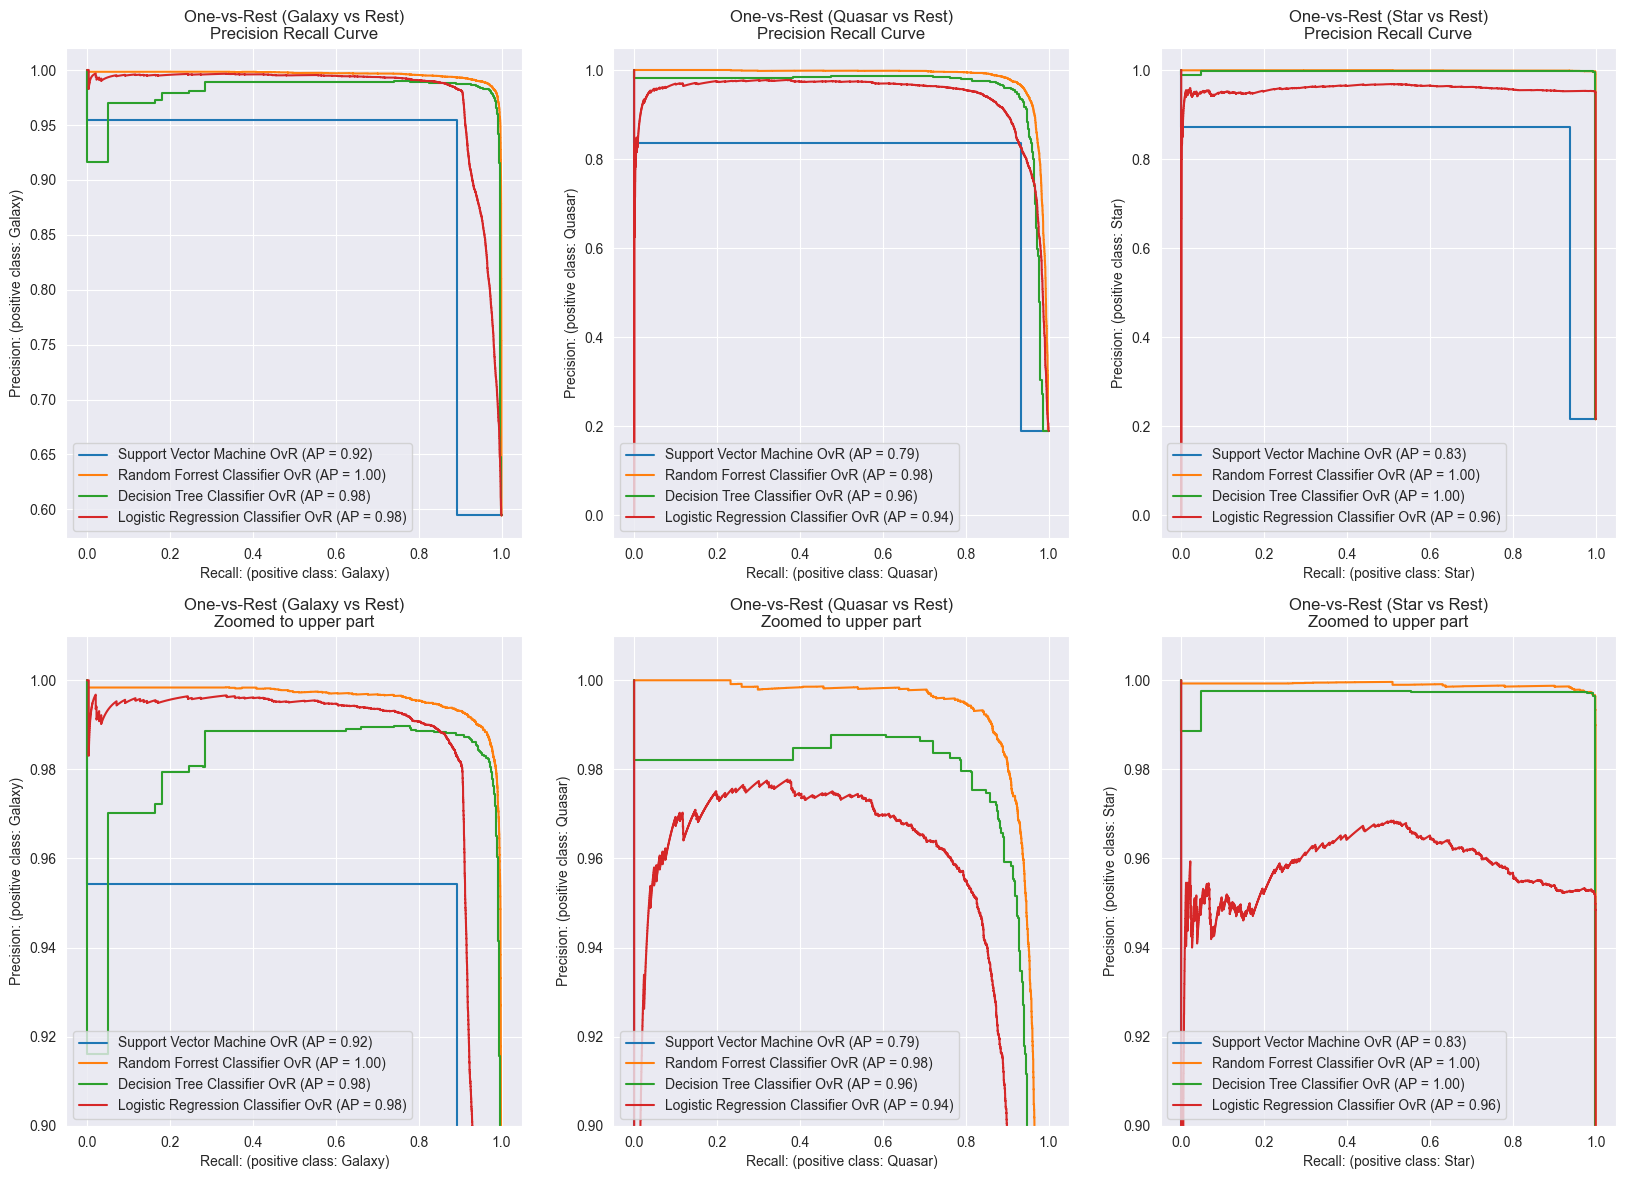

In [6]:
import matplotlib.pyplot as plt

# compare ovr roc curves for each model
"""
the mapping from labels to numbers is as follows
GALAXY  = 0 = [1, 0, 0]
QSO     = 1 = [0, 1, 0]
STAR    = 2 = [0, 0, 1]
"""

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

# for galaxy
for i, class_name in enumerate(["Galaxy", "Quasar", "Star"]):
    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        PrecisionRecallDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[0][i],

        )

    ax[0][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nPrecision Recall Curve")
    ax[0][i].set_xlabel(f"Recall: (positive class: {class_name})")
    ax[0][i].set_ylabel(f"Precision: (positive class: {class_name})")

    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        PrecisionRecallDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[1][i],

        )

    ax[1][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nZoomed to upper part")
    ax[1][i].set_xlabel(f"Recall: (positive class: {class_name})")
    ax[1][i].set_ylabel(f"Precision: (positive class: {class_name})")
    ax[1][i].set_ylim((0.9, 1.01))

According to the Precision Recall Curve, the Random Forrest classifier seems to be the overall best model (Orange line). The Support Vector Machine seems to be the least well performing since it is constantly
below all the other curves.

For Logistic Regression and the Decision Tree , this is not true. For Galaxy vs Rest, there are thresholds, when where the Logistic regression curve (red) is above the decision tree curve (green) but for the other two classes this is not true.
So for two out of three classes the Decision Tree is superior to the Logistic Regression and for one there are thresholds where logistic regression performs better. This means, that when a higher Precision is desired for the class Galaxy,
then the logistic regression would be preferred over a decision tree (neglecting that random forrest is still better).

## Analyze the ROC Curves for each Class individually
this helps to understand the overall classification performance among different thresholds regardless of the class imbalance
The ROC Curve tells us how good each classifier can separate the different classes from each other

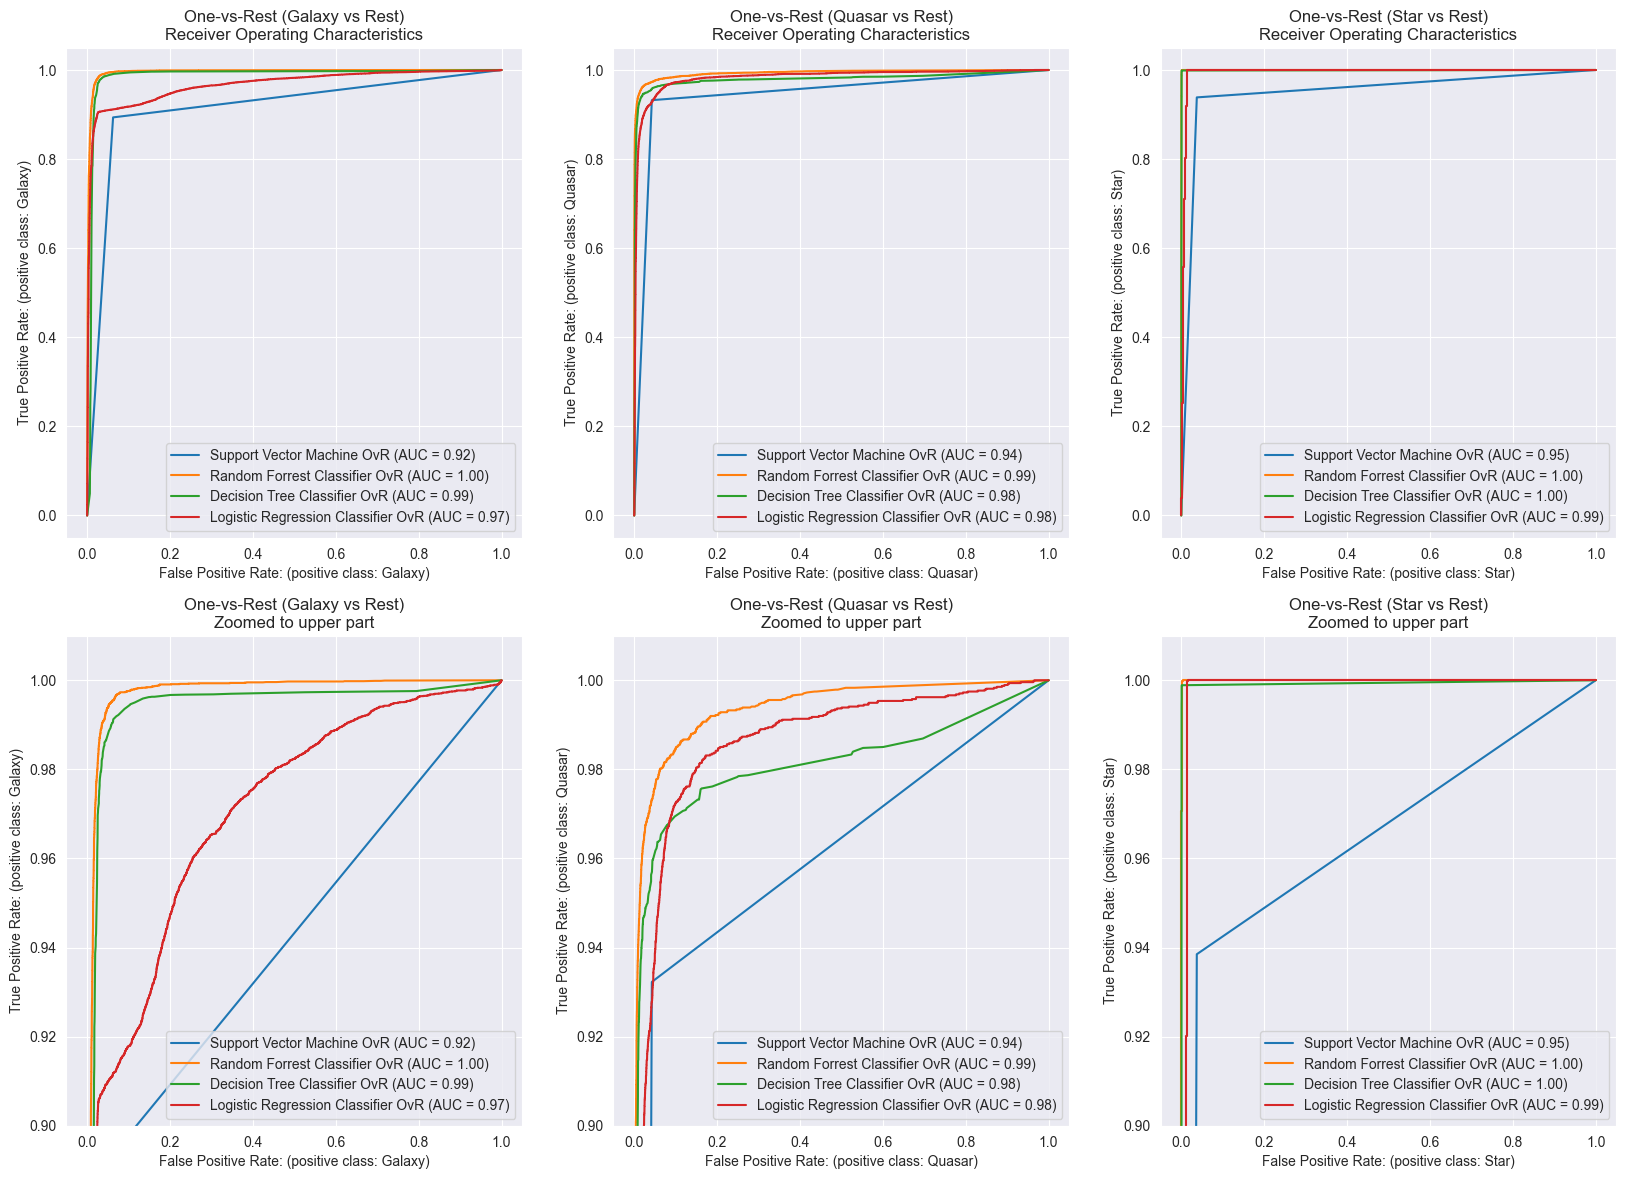

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(20, 14))

# for galaxy
for i, class_name in enumerate(["Galaxy", "Quasar", "Star"]):
    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[0][i],

        )

    ax[0][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nReceiver Operating Characteristics")
    ax[0][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[0][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")

    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[1][i],

        )

    ax[1][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nZoomed to upper part")
    ax[1][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylim((0.9, 1.01))

The ROC curves show a similar image than precision recall curve. The Random Forrest Classifier tends to be superior to all other models for all classes.
AS well as the Support Vector Machine tends to be Inferior.

Logistic Regression and Decision tree are not clearly superior or inferior, this differs for each threshold and feature, since the curves cross in for classes Quasar and Star.
For Galaxy, the decision tree seems to be superior to the logistic regression.

# Plot the feature weights of the logistic regression model

In [8]:
DataFrame(model_configurations["log_reg"]["estimator"].coef_, columns=model_configurations["log_reg"]["estimator"].feature_names_in_, index=["GALAXY", "QUASAR", "STAR"])

,u,g,r,i,z,redshift,plate
GALAXY,-0.655723,37.417043,-17.265189,-19.028286,-2.265907,-2.028355,-0.234393
QUASAR,-9.772279,-17.776582,-7.183012,31.499845,0.000000,42.745623,-0.838419
STAR,6.015958,-3.387436,0.000000,0.000000,0.904546,-1052.184386,0.300896


The table shows the feature weights of each feature for each class for the logistic regression.

In general, it turns out the plate number has low impact on all the classes. Which is not unexpected since in each area of the sky all the classes will be present.
For Galaxies, it seems that the green (g), red (r) and near infrared (i) filter value had the highest impact.

For Quasars, it was also the near infrared and green filed as well as the redshift.
For Stars the highest weight was given to the redshift while red and near infrared filter are not even considered.

# Check out the weight matrix for the  Support Vector machine

In [9]:
DataFrame(model_configurations["svm"]["estimator"].coef_, columns=model_configurations["log_reg"]["estimator"].feature_names_in_, index=["GALAXY", "QUASAR", "STAR"])

,u,g,r,i,z,redshift,plate
GALAXY,0.534760,12.122131,-5.400589,-5.937095,-1.947127,-0.466429,-0.078527
QUASAR,-1.706084,-4.584791,-3.985131,8.072623,1.157385,12.095282,-0.263778
STAR,1.388482,-0.927662,-0.038276,-0.903957,2.056958,-86.448400,0.471024


It is interesting to see that the weights from the SVM are completely different from the Logistic regression.
It turns out that the over all weights are smaller. The features with the most impact for the classes however remain the same.
This is not unexpected since they both had the same data to train on.

The feature importance is similar to logistic regression.

# Analyze the depth of the Decision tree
display the first level of nodes

In [10]:
model_configurations["decision_tree"]["estimator"].get_depth()

10

[Text(0.4230769230769231, 0.875, 'x[5] <= 0.004\ngini = 0.667\nsamples = 74999\nvalue = [24999.667, 24999.667, 24999.667]'),
 Text(0.15384615384615385, 0.625, 'x[5] <= -0.004\ngini = 0.017\nsamples = 16581\nvalue = [215.326, 3.516, 24999.667]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 5\nvalue = [2.804, 0.0, 0.0]'),
 Text(0.23076923076923078, 0.375, 'x[5] <= -0.0\ngini = 0.017\nsamples = 16576\nvalue = [212.522, 3.516, 24999.667]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'x[5] <= 0.893\ngini = 0.5\nsamples = 58418\nvalue = [24784.341, 24996.151, 0.0]'),
 Text(0.5384615384615384, 0.375, 'x[4] <= 19.797\ngini = 0.253\nsamples = 44981\nvalue = [23893.879, 4166.318, 0.0]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'x[1] <= 22.366\ngini = 0.079\nsamples = 13437\nvalue = [890.462, 20829

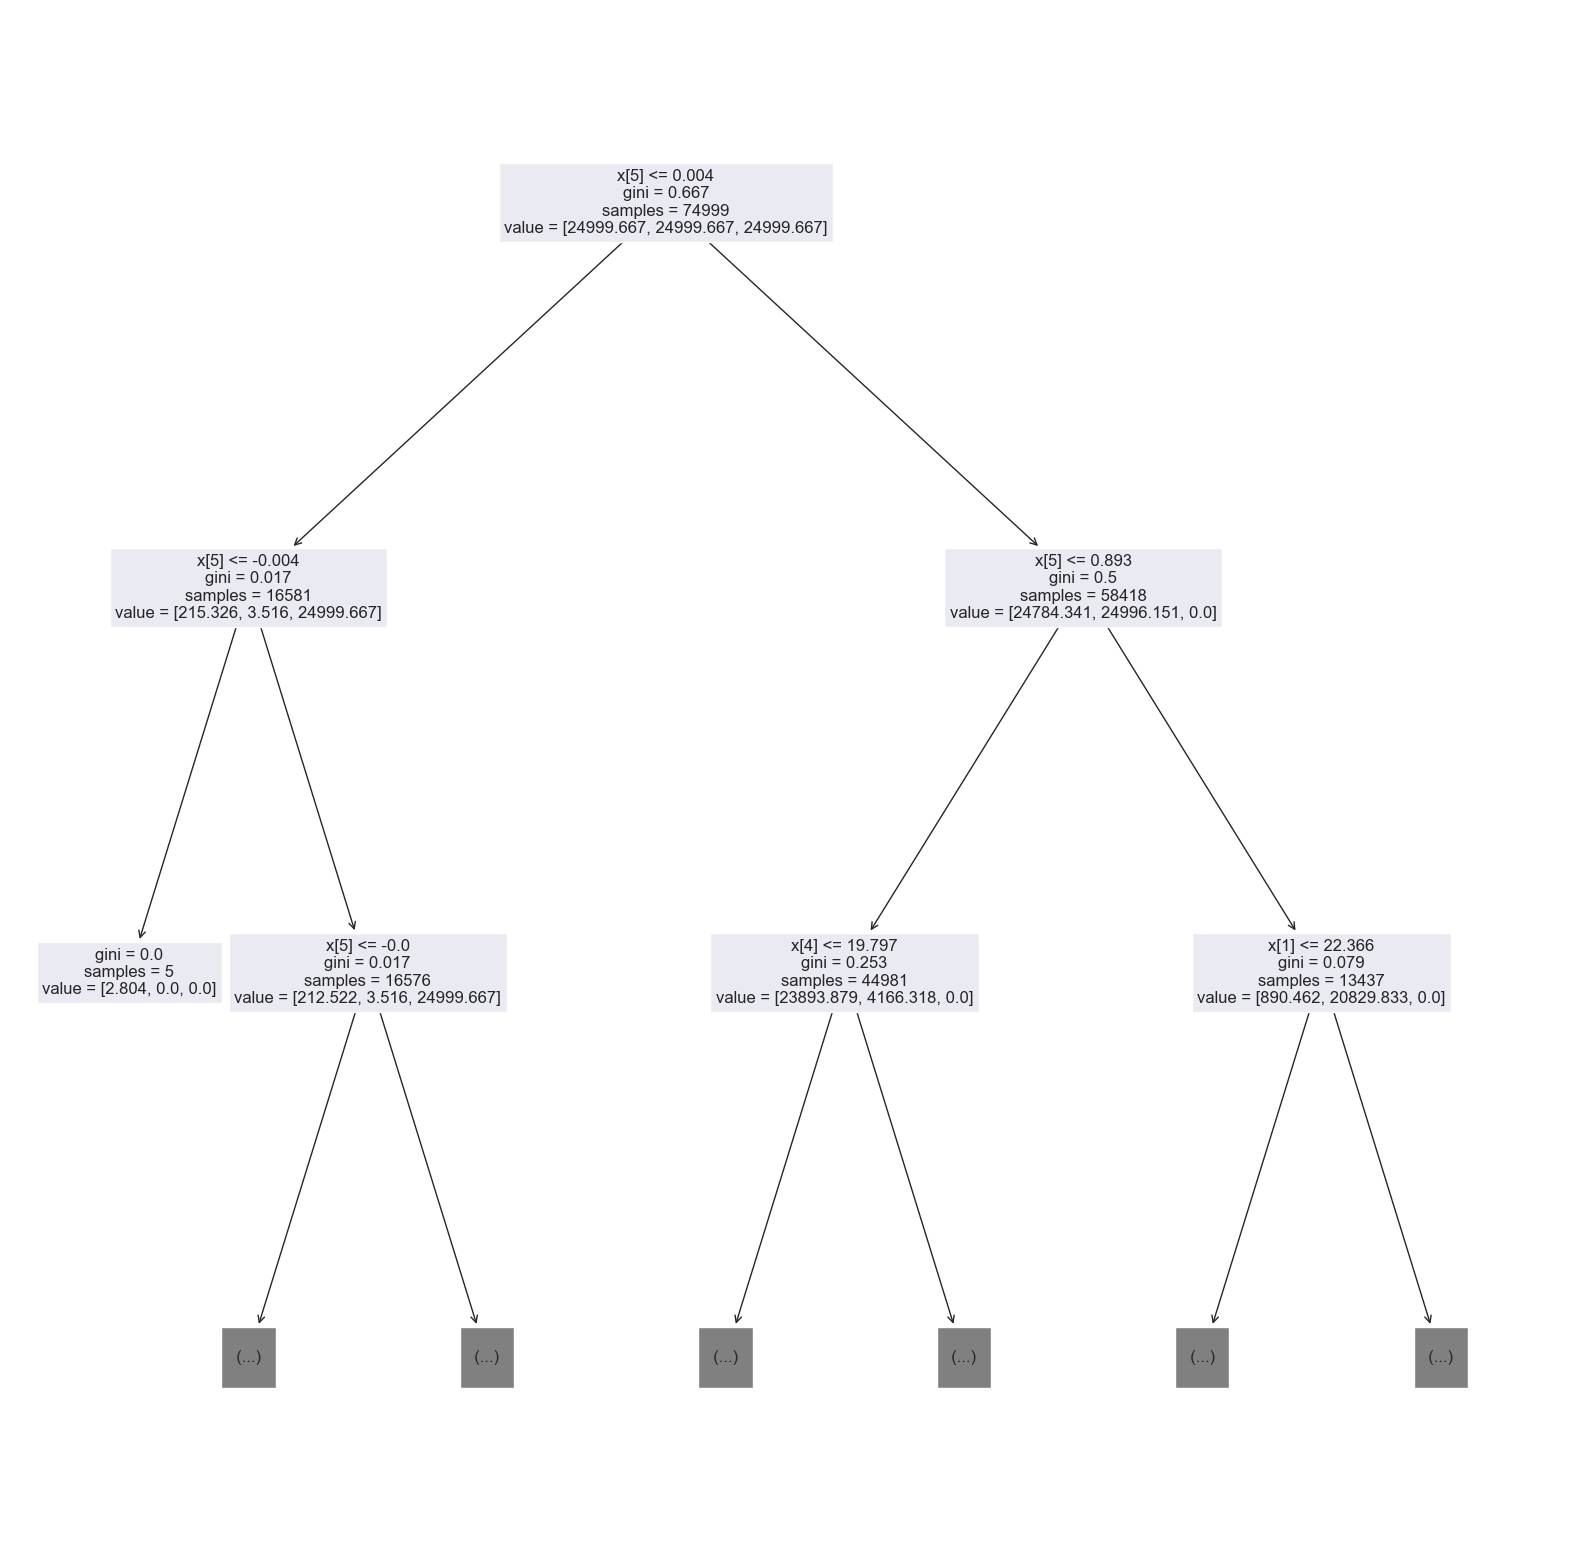

In [30]:
from sklearn.tree import plot_tree
fig, ax  = plt.subplots(1)
fig.set_size_inches(20, 20)
plot_tree(model_configurations["decision_tree"]["estimator"], max_depth=2, fontsize=12, ax=ax)

In [26]:
model_configurations["decision_tree"]["estimator"].feature_names_in_

array(['u', 'g', 'r', 'i', 'z', 'redshift', 'plate'], dtype=object)

looking at the first layer in the tree we see that the feature that was chosen as a root split is feature 5 which is the redshift.
This means, that the redshift provided the best split in terms of homogeneity in the resulting subclasses.

Considering the findings of the Data Analysis, it was already seen, that the redshift is a strong indication for the class Star since it has a fairly small redshift
compared to the other classes. (The boxplot of the redshift showed it)

This can also be seen on the left side, the complete left path ends in layer 2 with only one class left which is galaxy.
it was also observed that the redshift had the high weights in the SVM as well as Logistic regression.